In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression
import seaborn as sns
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.datasets import make_regression


## Exploratory Data Analysis

In [2]:
data = pd.read_csv('GercekZamanliTuketim-01012016-28112019.csv', encoding = 'unicode_escape')

In [3]:
data.shape

(34248, 3)

In [4]:
data.tail(10)

,Tarih,Saat,Tüketim Miktarý (MWh)
34238,28.11.2019,14:00,"36.231,59"
34239,28.11.2019,15:00,"36.646,25"
34240,28.11.2019,16:00,"37.780,29"
34241,28.11.2019,17:00,"39.549,01"
34242,28.11.2019,18:00,"39.430,52"
34243,28.11.2019,19:00,"38.368,05"
34244,28.11.2019,20:00,"37.397,13"
34245,28.11.2019,21:00,"36.638,64"
34246,28.11.2019,22:00,"35.557,84"
34247,28.11.2019,23:00,"33.986,37"


In [5]:
data.columns = ['Date', 'Hour', 'Consumption']

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34248 entries, 0 to 34247
Data columns (total 3 columns):
Date           34248 non-null object
Hour           34248 non-null object
Consumption    34248 non-null object
dtypes: object(3)
memory usage: 802.8+ KB


Arrange datatypes

In [7]:
data['Date'] = pd.to_datetime(data['Date'], format='%d.%m.%Y').dt.strftime('%Y-%m-%d')
data['Consumption'] = data['Consumption'].str.replace('.','')
data['Consumption'] = data['Consumption'].str.replace(',','.')
data['Consumption'] = data['Consumption'].astype(str).astype(float)

In [8]:
data.head()

,Date,Hour,Consumption
0,2016-01-01,00:00,26277.24
1,2016-01-01,01:00,24991.82
2,2016-01-01,02:00,23532.61
3,2016-01-01,03:00,22464.78
4,2016-01-01,04:00,22002.91


check: Is there any missing date?

In [9]:
data=data.set_index('Date')
pd.date_range(start = '2016-01-01', end = '2019-11-01').difference(data.index)
data.reset_index(level=0, inplace=True)

2016-03-27 is missing. Now checking each day have 24 Hours?

In [10]:
data=data.set_index('Date')
a = data.groupby(['Date']).agg('count')
data.reset_index(level=0, inplace=True)
a['Hour'].unique()

array([24], dtype=int64)

In [11]:
tobeconcanated = data[(data['Date']<='2016-03-26') & (data['Date']>='2016-03-20')]
tobeconcanated = tobeconcanated.groupby('Hour', as_index=False)['Consumption'].mean()
ToBeInserted = data[data['Date'] == '2016-03-20'].replace('2016-03-20', '2016-03-27')
ToBeInserted = pd.merge(ToBeInserted[['Date','Hour']], tobeconcanated , how='left', on='Hour' )
data = pd.concat ([data, ToBeInserted])


In [12]:
data = data.sort_values(by=['Date', 'Hour'])

In [13]:
data.index.min()

0

In [14]:
duplicate_rows_df = data[data.duplicated()]
print("number duplicate rows:", duplicate_rows_df.shape)

number duplicate rows: (0, 3)


In [15]:
print(data.isnull().sum())

Date           0
Hour           0
Consumption    0
dtype: int64


In [16]:
data['Consumption_Lag_48']=data['Consumption'].shift(48)
data['Consumption_Lag_168']=data['Consumption'].shift(168)

In [17]:
data_train = data[data['Date']<'2019-11-01'].dropna()
data_test = data[data['Date']>='2019-11-01'].dropna()

In [18]:
data_test

,Date,Hour,Consumption,Consumption_Lag_48,Consumption_Lag_168
33576,2019-11-01,00:00,29417.56,27154.21,29563.43
33577,2019-11-01,01:00,28133.75,26157.42,28242.90
33578,2019-11-01,02:00,27358.60,25373.88,27258.74
33579,2019-11-01,03:00,26780.09,24911.43,26739.84
33580,2019-11-01,04:00,26511.54,24836.11,26555.35
33581,2019-11-01,05:00,27002.74,25233.76,26857.36
33582,2019-11-01,06:00,27945.43,26296.00,27783.77
33583,2019-11-01,07:00,29120.27,27575.60,28969.45
33584,2019-11-01,08:00,32815.46,31667.27,32153.21
33585,2019-11-01,09:00,34569.09,33138.17,33615.22


In [19]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    _abs = np.abs((y_true - y_pred) / y_true)
    return np.mean(_abs) * 100, _abs

In [20]:
naive_forecast_48, _abs48 = mean_absolute_percentage_error(data_test['Consumption'],data_test['Consumption_Lag_48'])
naive_forecast_168, _abs168 = mean_absolute_percentage_error(data_test['Consumption'],data_test['Consumption_Lag_168'])
print("Mape for Lag_48:", naive_forecast_48)
print("Mape for Lag_168:", naive_forecast_168)

naive_forecast_48 = [naive_forecast_48]
naive_forecast_168 = [naive_forecast_168]

Mape for Lag_48: 7.706542119696038
Mape for Lag_168: 3.061607839097648


## b)

Create x and y array for train data

In [21]:
Feature_List  = data_train.columns.to_list()
feature = [s for s in Feature_List if "Consumption_Lag" in s]
# Separating out the features
x_train = data_train.loc[:, feature].values
# Separating out the target
y_train = data_train.loc[:,['Consumption']].values 
model = LinearRegression().fit(x_train, y_train)
Feature_List  = data_test.columns.to_list()
feature = [s for s in Feature_List if "Consumption_Lag" in s]
# Separating out the features
x_test = data_test.loc[:, feature].values
# Separating out the target
y_test = data_test.loc[:,['Consumption']].values 
y_pred = model.predict(x_test)
print('predicted consumption for each hour in day of  2019-11-01: ', y_pred, sep='\n')
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
linear_mape, _abslinear_mape = mean_absolute_percentage_error(df['Actual'], df['Predicted'])
print( 'Mape for linear regression: '+ str(linear_mape))

   

predicted consumption for each hour in day of  2019-11-01: 
[[28931.61454172]
 [27781.88136361]
 [26911.78646317]
 [26436.9808162 ]
 [26297.15321807]
 [26615.30020106]
 [27539.95942282]
 [28697.39852084]
 [32018.63867675]
 [33411.044316  ]
 [33206.63225319]
 [33360.67796768]
 [31149.22474601]
 [31322.47572862]
 [33010.55175587]
 [33430.62541801]
 [34321.17044437]
 [35843.14662819]
 [36326.17850135]
 [35715.89054844]
 [34814.83083408]
 [33769.54553915]
 [32752.38245218]
 [31193.32927402]
 [29588.12987268]
 [28252.22275177]
 [27537.84040265]
 [26980.36162732]
 [26780.52220812]
 [26965.88435114]
 [27438.31369723]
 [27710.81420613]
 [30651.10521202]
 [31849.73855576]
 [31907.94091121]
 [32071.40310562]
 [30819.27893517]
 [31248.43922168]
 [32060.5765459 ]
 [32184.92967356]
 [32878.93612954]
 [34118.43476723]
 [35386.11134164]
 [34746.1384264 ]
 [33892.77748892]
 [32918.87809573]
 [31932.18470402]
 [30481.3438894 ]
 [28640.08053324]
 [27485.31004263]
 [26537.81256639]
 [25921.74686978]
 [25

 [33773.33580555]]
Mape for linear regression: 3.9011586686688005


In [22]:
linear_mape, linear_forecast = mean_absolute_percentage_error(df['Actual'], df['Predicted'])

In [23]:
linear_forecast = linear_forecast.tolist()

In [24]:
print('intercept:', model.intercept_)
print('slope:', model.coef_)

intercept: [1617.88420781]
slope: [[0.3253104  0.62510282]]


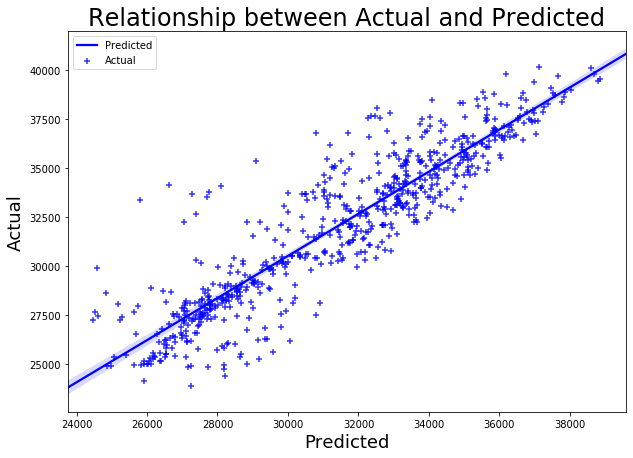

In [26]:
# Regression plot using seaborn.
fig = plt.figure(figsize=(10,7))
sns.regplot(x=df.Predicted,y=df.Actual,color='blue', marker='+')


# Legend, title and labels.
plt.legend(labels=['Predicted','Actual'])
plt.title('Relationship between Actual and Predicted', size=24)
plt.xlabel('Predicted', size=18)
plt.ylabel('Actual', size=18);

## c

In [27]:
def linear_regression (data_train, data_test):
    Feature_List  = data_train.columns.to_list()
    feature = [s for s in Feature_List if "Consumption_Lag" in s]
    # Separating out the features
    x_train = data_train.loc[:, feature].values
    # Separating out the target
    y_train = data_train.loc[:,['Consumption']].values 
    model = LinearRegression().fit(x_train, y_train)
    Feature_List  = data_test.columns.to_list()
    feature = [s for s in Feature_List if "Consumption_Lag" in s]
    # Separating out the features
    x_test = data_test.loc[:, feature].values
    # Separating out the target
    y_test = data_test.loc[:,['Consumption']].values 
    y_pred = model.predict(x_test)
    #print('predicted response:', y_pred, sep='\n')
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    
    return mean_mape

    
    



In [28]:
hours = data.Hour.unique()
hours = hours.tolist()
seperate_forecast=[]
for i in hours:
    mean_mape = linear_regression(data_train[data_train['Hour']==i], data_test[data_test['Hour']==i])
    print('Mape for ' + i + ': ' + str(mean_mape))
    seperate_forecast.append(mean_mape)

Mape for 00:00: 3.008959868554221
Mape for 01:00: 3.1178184844637213
Mape for 02:00: 3.129129622575984
Mape for 03:00: 3.097199253511972
Mape for 04:00: 3.017639677274297
Mape for 05:00: 3.0024304578943157
Mape for 06:00: 3.2621047206918683
Mape for 07:00: 3.9169501413569376
Mape for 08:00: 4.59201769720659
Mape for 09:00: 4.946234126570637
Mape for 10:00: 5.112778429839699
Mape for 11:00: 5.466006951189922
Mape for 12:00: 5.508225305917166
Mape for 13:00: 5.726370688118855
Mape for 14:00: 6.036872687314928
Mape for 15:00: 5.664878300039474
Mape for 16:00: 4.964251058488835
Mape for 17:00: 4.43444201665517
Mape for 18:00: 3.519784502822508
Mape for 19:00: 3.1304241270519415
Mape for 20:00: 3.01141081515684
Mape for 21:00: 2.9466232436658375
Mape for 22:00: 3.009735503115461
Mape for 23:00: 3.0334590812793416


## d

## Wide format 


In [29]:
data_train.head()

,Date,Hour,Consumption,Consumption_Lag_48,Consumption_Lag_168
168,2016-01-08,00:00,28602.02,29189.27,26277.24
169,2016-01-08,01:00,27112.37,27614.02,24991.82
170,2016-01-08,02:00,25975.34,26578.97,23532.61
171,2016-01-08,03:00,25315.55,25719.19,22464.78
172,2016-01-08,04:00,25128.15,25864.63,22002.91


In [30]:
data_wide = data.pivot(index='Date', columns='Hour', values=['Consumption_Lag_48', 'Consumption_Lag_168', 'Consumption'])
data_wide.columns = ['Lag_day_' + str(i) + '_' + str(j) for i in (2, 7) for j in range(24)] + ['Consumption_{}'.format(i) for i in range(24)]
data_wide = data_wide.dropna().reset_index()


In [31]:
data_wide.head(5)

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
1,2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2,2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
3,2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
4,2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87


In [32]:
data_train_lasso = data_wide[data_wide['Date']<'2019-11-01'].dropna()
data_test_lasso = data_wide[data_wide['Date']>='2019-11-01'].dropna()

In [33]:
data_test_lasso

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
1393,2019-11-01,27154.21,26157.42,25373.88,24911.43,24836.11,25233.76,26296.00,27575.60,31667.27,...,35732.88,35859.75,36268.51,37011.89,37199.91,36056.96,35130.19,33947.64,32877.69,31590.75
1394,2019-11-02,29331.55,28111.63,27264.60,26644.38,26512.81,26845.26,27760.58,28656.62,32350.30,...,30714.39,30708.09,31533.21,33249.77,35002.42,34648.38,33781.78,32886.05,31760.63,30372.14
1395,2019-11-03,29417.56,28133.75,27358.60,26780.09,26511.54,27002.74,27945.43,29120.27,32815.46,...,25586.89,26163.98,27469.09,29926.49,32603.41,32703.07,32252.33,31463.89,30436.52,29055.90
1396,2019-11-04,29562.79,28256.30,27135.27,26480.50,26377.98,26551.33,26896.90,27288.43,29804.68,...,33782.94,34129.31,35343.25,36870.79,37507.08,36499.00,35701.66,34727.06,33682.37,32248.40
1397,2019-11-05,28453.56,26982.67,25789.05,25126.01,24921.85,24928.02,24992.22,24123.50,23869.05,...,33744.36,34057.11,35347.33,36758.79,37544.77,36560.38,35709.24,34615.30,33697.41,32227.20
1398,2019-11-06,27437.59,26099.72,25424.28,24896.77,24896.90,25330.16,26491.28,28166.73,31894.38,...,32993.36,33466.84,34945.47,36647.84,37437.52,36428.55,35463.24,34473.53,33416.01,31977.78
1399,2019-11-07,30282.48,28870.49,28060.26,27428.39,27219.83,27611.34,28607.40,29891.20,33332.65,...,32951.83,33500.50,34877.64,36644.03,37394.28,36504.89,35595.11,34612.47,33572.96,32140.43
1400,2019-11-08,30160.59,28729.17,27923.43,27371.76,27201.66,27616.48,28670.00,29957.97,32775.58,...,32856.96,33428.16,34863.65,36439.99,36747.48,35642.08,34776.28,33940.11,33093.52,31998.52
1401,2019-11-09,30229.78,28803.14,28005.97,27325.40,27204.94,27474.37,28571.91,29760.15,32859.33,...,31039.89,31158.83,32065.01,33631.97,35262.96,34650.20,33769.67,32902.88,32015.60,30746.20
1402,2019-11-10,30125.52,28693.55,27812.02,27200.62,27163.68,27259.20,28491.06,29757.03,32662.73,...,26064.37,26723.74,28097.23,30307.23,32437.23,32256.55,31614.02,31046.49,30239.24,28347.94


In [34]:
def lasso_regression (data_train, data_test, hour):
    Feature_List  = data_train.columns.to_list()
    feature = [s for s in Feature_List if "Lag" in s]
    # Separating out the features
    x_train = data_train.loc[:, feature].values
    # Separating out the target
    y_train = data_train.loc[:,['Consumption_'+ str(hour)]].values
    y_train = np.ravel(y_train)
    alpha = np.logspace(-10, 1, 400)
    lasso = LassoCV(cv=10, normalize=True, tol=0.001, selection='random', random_state=42, alphas=alpha,max_iter=5000)
    lasso.fit(x_train, y_train)
    # Separating out the features
    x_test = data_test.loc[:, feature].values
    # Separating out the target
    y_test = data_test.loc[:,['Consumption_'+ str(hour)]].values 
    y_pred = lasso.predict(x_test)
    #print('predicted response:', y_pred, sep='\n')
    df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
    mean_mape, mape_abs =  mean_absolute_percentage_error(df['Actual'], df['Predicted'])
    
    return mean_mape


In [35]:
data_train_lasso.head()

,Date,Lag_day_2_0,Lag_day_2_1,Lag_day_2_2,Lag_day_2_3,Lag_day_2_4,Lag_day_2_5,Lag_day_2_6,Lag_day_2_7,Lag_day_2_8,...,Consumption_14,Consumption_15,Consumption_16,Consumption_17,Consumption_18,Consumption_19,Consumption_20,Consumption_21,Consumption_22,Consumption_23
0,2016-01-08,29189.27,27614.02,26578.97,25719.19,25864.63,25918.59,27091.94,28533.05,33203.34,...,36555.58,36190.41,37031.72,37773.70,35930.69,34710.46,33907.65,33048.69,33220.16,32021.60
1,2016-01-09,28763.95,27284.84,26321.95,25748.49,25636.58,25932.52,26963.74,28444.83,32804.27,...,33524.80,32951.39,33655.89,35045.14,34407.27,33494.32,32624.31,32097.79,32176.63,30760.17
2,2016-01-10,28602.02,27112.37,25975.34,25315.55,25128.15,25356.22,26338.72,28086.42,32702.24,...,29089.83,29447.75,30569.07,32006.15,31706.26,31305.87,30870.26,30462.79,30537.75,28857.66
3,2016-01-11,29906.93,28061.98,26808.78,25798.80,25820.46,26035.77,26451.24,26853.42,30627.32,...,36383.06,36013.19,36848.54,37368.40,35697.30,34482.37,33526.95,32634.16,32791.35,31147.83
4,2016-01-12,28890.37,27133.75,25656.13,24937.87,24538.16,24616.05,24478.14,23813.35,24676.92,...,34934.00,34785.11,35690.28,36566.50,35055.97,33912.94,33131.98,32332.76,32523.14,30906.87


In [36]:
lasso_forecast = []
hours = range(24)
for hour in hours:
    output = lasso_regression(data_train_lasso, data_test_lasso, hour)
    print('Mape for'+' '+ 'Hour'+' '+str(hour)+':' + str(output))
    lasso_forecast.append(output)

Mape for Hour 0:1.7111792345268284
Mape for Hour 1:1.7067715564545136
Mape for Hour 2:1.7664670534657898
Mape for Hour 3:1.72321424145114
Mape for Hour 4:1.6325436895577208
Mape for Hour 5:1.6254136893229354
Mape for Hour 6:1.6839669568779099
Mape for Hour 7:2.2368878845106845
Mape for Hour 8:2.8588838015852684
Mape for Hour 9:3.2181413169245316
Mape for Hour 10:3.4616301587852107
Mape for Hour 11:3.7210974812431012
Mape for Hour 12:3.8096816202853705
Mape for Hour 13:3.8567502465914427
Mape for Hour 14:3.962928392360617
Mape for Hour 15:3.5701593900772313
Mape for Hour 16:2.97568348315394
Mape for Hour 17:2.386863640121362
Mape for Hour 18:2.018720914473829
Mape for Hour 19:1.8826723122987092
Mape for Hour 20:1.6673368224207767
Mape for Hour 21:1.713129787436406
Mape for Hour 22:1.6671907023027923
Mape for Hour 23:1.5624372065091623


## f

In [37]:
naive_forecast_168

[3.061607839097648]

In [38]:
dataframe = pd.DataFrame(
    {'naive_168': _abs168,
     'naive_48': _abs48,
     'linear_forecast': linear_forecast
     #'seperate_hour_forecast': seperate_forecast,
     #'lasso_forecast': lasso_forecast
    })


In [39]:
dataframe_boxplot = pd.DataFrame(
    {
     'seperate_hour_forecast': seperate_forecast,
     'lasso_forecast': lasso_forecast
    })


In [40]:
dataframe

,naive_168,naive_48,linear_forecast
0,0.004959,0.076939,0.016519
1,0.003880,0.070248,0.012507
2,0.003650,0.072545,0.016332
3,0.001503,0.069778,0.012812
4,0.001652,0.063196,0.008087
5,0.005384,0.065511,0.014348
6,0.005785,0.059023,0.014509
7,0.005179,0.053044,0.014522
8,0.020181,0.034989,0.024282
9,0.027593,0.041393,0.033499


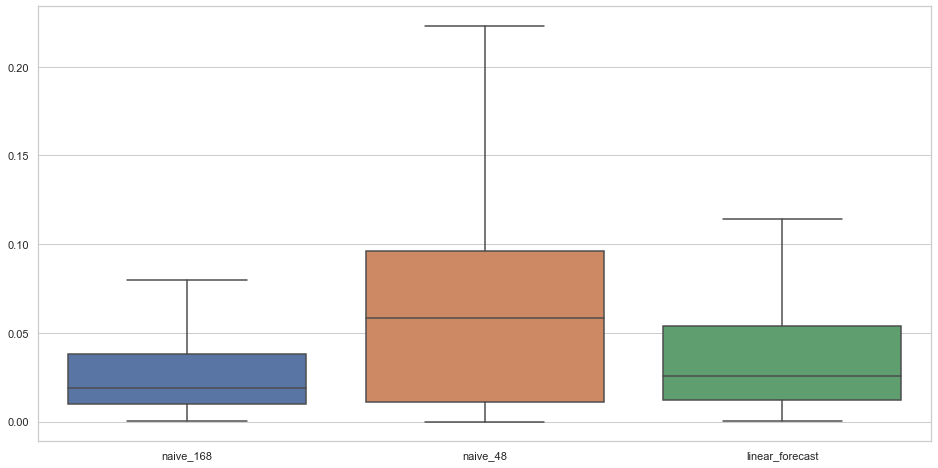

In [41]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=dataframe, showfliers=False)

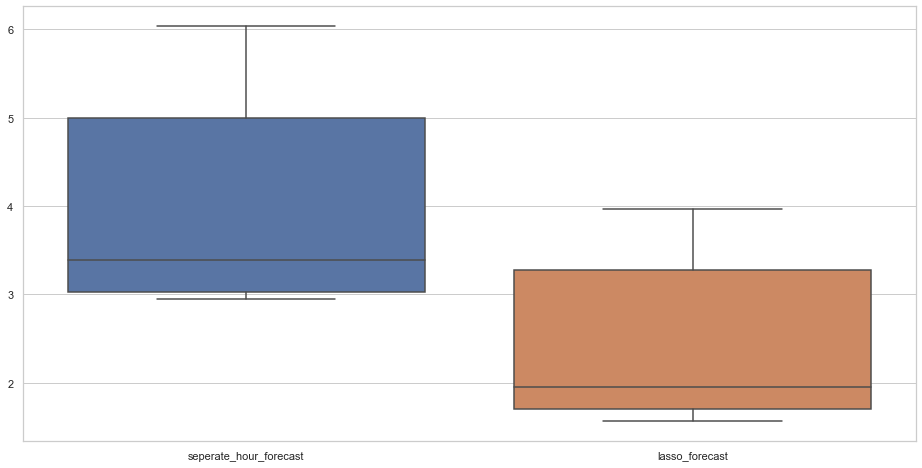

In [42]:
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=dataframe_boxplot, showfliers=False)

I think, best approch is the naive forecast because of the low mape values compare to the other approaches. The reason  why there are two seperate box plot graphs is the scale problem of approches.